In [1]:
%matplotlib inline

# Assignment 3

**DUE: Sunday November 7, 2021 11:59pm**

Turn in the assignment via Canvas.

To write legible answers you will need to be familiar with both [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and [Latex](https://www.latex-tutorial.com/tutorials/amsmath/)

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Runtime→→Restart runtime) and then run all cells (in the menubar, select Runtime→→Run All).

Make sure you fill in any place that says "YOUR CODE HERE" or "YOUR ANSWER HERE", as well as your name below:

In [2]:
NAME = "Sanjay Shrikanth"
STUDENT_ID = "1718751"

## Question 1 - Logistic Regression
---
In this question, you will build a system for predicting patient deaths in the Intensive Care Unit (ICU) using the large [PhysioNet Computing in Cardiology Challenge 2012 dataset](https://physionet.org/content/challenge-2012/1.0.0/). For each patient in the dataset, demographic variables and time series of physiological variables were collected during their stay in the ICU. 

The risk prediction system you will build could in principle be used to flag patients as being at risk of death so that physicians could intervene and improve their outcome. To be confident about the impact of such a system, you would need to run an experiment. In this question, you will use a model in order to estimate the potential impact of the system.

The data you will be working with is all available from [PhysioNet](https://physionet.org/challenge/2012/). You will be looking at only the data in "Training set A". The patient data files are [https://archive.physionet.org/challenge/2012/set-a.zip](here), and the outcomes file is [https://archive.physionet.org/challenge/2012/Outcomes-a.txt](here).





#### Downloading and Reading in the Data

First, we download the physiological data and read in patient outcomes file (links above).

We want this data to be read from text files and assembled into a dataframe. To do so, please run the following code which will first define a function that reads a text file, and then runs that function on all the files and assembles the outputs into a single dataframe.

#### Downloading the data

In [3]:
!wget https://archive.physionet.org/challenge/2012/set-a.zip -O ./set-a.zip
import zipfile
with zipfile.ZipFile('./set-a.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

--2021-11-08 06:27:34--  https://archive.physionet.org/challenge/2012/set-a.zip
Resolving archive.physionet.org (archive.physionet.org)... 128.30.30.88
Connecting to archive.physionet.org (archive.physionet.org)|128.30.30.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7938449 (7.6M) [application/zip]
Saving to: ‘./set-a.zip’

./set-a.zip         100%[===================>]   7.57M  27.4MB/s    in 0.3s    

2021-11-08 06:27:34 (27.4 MB/s) - ‘./set-a.zip’ saved [7938449/7938449]



#### Reading in data

In [4]:
import pandas as pd
import numpy as np
import glob

def comp_patient(patdat, attrs):
    patdat[patdat == -1.0] = float('NaN')
    patdat_dict = {}
    for attr in attrs:
        patdat_dict[attr] = [patdat["Value"][patdat["Parameter"]==attr].mean(axis = 0)]
    return patdat_dict


attrs = ["Age", "Gender", "Height", "Weight", "Urine", 
         "HR", "Temp", "NIDiasABP", "SysABP", "DiasABP", "pH",
         "PaCO2", "PaO2", "Platelets", "MAP", "K", "Na", "FiO2", "GCS", "RecordID"]


full_dat  = pd.DataFrame(columns = attrs)

# Now let's take the list "all_pat_dat" and assemble it into a dataframe.
filenames = sorted(glob.glob("/content/set-a/*.txt"))
for filename in filenames:
    data = open(filename)
    patient_dat_full = pd.read_csv(data, delimiter=',')
    patient_dat = pd.DataFrame.from_dict(comp_patient(patient_dat_full, attrs))
    full_dat = full_dat.append(patient_dat)

outcome_dat = pd.read_csv("https://archive.physionet.org/challenge/2012/Outcomes-a.txt")
outcome_dat[outcome_dat == -1] = float('NaN') # set all -1 to NaNs
full_dat_out = full_dat.merge(outcome_dat, left_on='RecordID', right_on='RecordID')
full_dat_out.replace([np.inf, -np.inf], np.nan)

col_means = full_dat_out.mean()
# Set everything that's NaN to the mean of that column:

# Note: we do this for simplicity. Strictly speaking, you should
# only use the training set to compute the column means

for i in range(full_dat_out.shape[1]):
    mask = np.isnan(np.array(full_dat_out.iloc[:,i]))
    full_dat_out.iloc[mask, i] = col_means[i]

print(full_dat_out.shape)

(4000, 25)


### a) Understanding the Data (2 points)
Looking at the files and the code provided above, explain:


*   What is the size of your input data? how many parameters exist in the data?
*   Exaplain what the code provided above is trying to achieve.



Based on the shape of the dataframe, the input data has a size of $4000$ with $25$ parameters. The provided code is extracting the data from the csv file and converting it to a dataframe that is categorized by the different features. With this dataframe processing, the data is now vectorized into different categories, so we can clean the data (like eliminating **NaN** values) and train a model on it for predictive purposes.

In [5]:
full_dat_out.head()

,Age,Gender,Height,Weight,Urine,HR,Temp,NIDiasABP,SysABP,DiasABP,pH,PaCO2,PaO2,Platelets,MAP,K,Na,FiO2,GCS,RecordID,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
0,54.0,0.0,169.787227,83.043044,171.052632,70.810811,37.357143,50.147059,118.591225,59.543420,7.521077,40.382018,147.987136,203.000000,81.055075,4.20,136.500000,0.549199,14.923077,132539.0,6.0,1.0,5.0,351.063772,0.0
1,76.0,1.0,175.300000,80.670588,151.560976,80.794118,36.939130,56.714286,113.411765,58.897059,7.395000,38.857143,210.142857,178.600000,76.940299,3.90,137.000000,0.560000,13.333333,132540.0,16.0,8.0,8.0,351.063772,0.0
2,44.0,0.0,169.787227,56.700000,124.951220,83.759259,37.800000,79.000000,125.687500,67.125000,7.495000,35.500000,134.500000,89.666667,90.437500,4.26,138.333333,0.500000,5.923077,132541.0,21.0,11.0,19.0,351.063772,0.0
3,68.0,1.0,180.300000,84.600000,545.833333,70.983333,36.223077,65.051724,118.591225,59.543420,7.521077,40.382018,147.987136,330.000000,81.055075,4.00,139.333333,0.549199,14.944444,132543.0,7.0,1.0,9.0,575.000000,0.0
4,88.0,0.0,169.787227,83.043044,62.131579,74.958333,36.880000,45.720930,118.591225,59.543420,7.521077,40.382018,147.987136,103.000000,81.055075,4.32,139.500000,0.549199,15.000000,132545.0,17.0,2.0,4.0,918.000000,0.0


### b) Run Logistic Regression (9 points)


Divide your data into training, validation, and test sets (60-20-20). 

Use the features `HR`, `Gender`, `age`, `temperature`, `weight`, `height`, `PaO2`, and  `PaCO2`, and fit a logistic regression model to predict in-hospital death. 

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# Split data in X and y using pandas functionality.
y_hospital = full_dat_out.iloc[:, -1]
X_hospital = full_dat_out.drop(columns=['In-hospital_death'])

features = ['HR', 'Gender', 'Age', 'Temp', 'Weight', 'Height', 'PaO2', 'PaCO2']
for f in X_hospital.columns.values:
  if f not in features:
    X_hospital = X_hospital.drop(columns=[f])


# Cast dataframes into numpy arrays
X = X_hospital.values
y = y_hospital.values

# Split into training and validation sets
x_set, X_test, y_set, y_test = train_test_split(X, y, test_size=0.2, random_state=144)
X_train, X_val, y_train, y_val = train_test_split(x_set, y_set, test_size=0.25, random_state=144)

print(len(X_train), len(X_val), len(X_test))
print(len(y_train), len(y_val), len(y_test), "\n")

# fit Logistic Regression Model
model = LogisticRegression(random_state=144).fit(X_train, y_train)
score_train =  model.score(X_train, y_train)
score_test = model.score(X_test, y_test)
print('Training Score: ', score_train)
print('Testing Score: ', score_test)

2400 800 800
2400 800 800 

Training Score:  0.8633333333333333
Testing Score:  0.8525


### c) ROC Curve (10 points)

Write a function that, for a given threshold (prob. threshold), calculates both the False Positive Rate (proportion of non-deaths identified as deaths by the model) and True Positive Rate (proportion of deaths correctly identified as such by the model) for your regression model. 

For 100 threshold values equally spaced from 0 to 1, plot the True Positive Rate vs. the False Positive Rate. Use the validation set.

This plot is known as an ROC curve. 


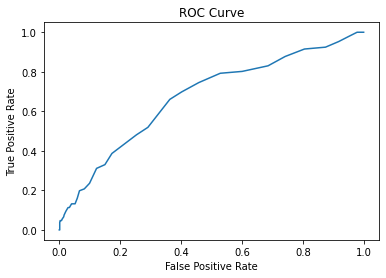

In [7]:
from sklearn import metrics
import matplotlib.pyplot as plt

def plot_ROC(thresholds):
  probs = model.predict_proba(X_val)
  probs = probs[:,1]  # positive class

  plot_x = np.empty(len(thresholds))
  plot_y = np.empty(len(thresholds))
  for i,t in enumerate(thresholds):
    tpc = fpc = fnc = tnc = 0
    for j, p in enumerate(probs):
      if p > t:
        if y_val[j] == 1:
          tpc+=1
        else:
          fpc+=1
      else:
        if y_val[j] == 1:
          fnc+=1
        else:
          tnc+=1

    plot_x[i] = tpc / (tpc + fnc)
    plot_y[i] = fpc / (fpc + tnc)

  plt.title('ROC Curve')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.plot(plot_y, plot_x)
  plt.show()

plot_ROC(np.linspace(0,1,101))

### d) Interpreting the ROC Curve (4 points)

Using the plot generated in Part (c), what is the False Positive Rate associated with correctly identifying 80% of patients at risk for death in the ICU? Why might a high false positive rate be appropriate in this setting? You can read the answer off the ROC curve plot.


Based on the graph, the False Positive Rate associated with *correctly* identifying 80\% of patients at risk for death is about **60\%**. This high false positive rate may be appropriate because when dealing with risks, a false positive is simply an extra precautionary classification. It is better for a doctor to preserve a high true positive rate at an expense for mis-identifying someone who has risk for death when they do not, as that determination is more on cautionary side than harmful. Based on the ROC trend, as the true positive rate increases, the false positive rate increases, so it is a necessary price for accuracy.


### e) Modelling Doctors' Decision-Making (6 points)

For this part, produce a short report that answers all the questions below. Include code that produces the numbers that you need.

At the beginning of their shift, a doctor reviews their patients' charts, and decides what intervention is needed for each patient. In the following parts, we will be trying to improve this process. We will consider a simplified version of what is going on. Suppose that if the doctor intervenes correctly, the patient will not die; suppose that the doctor has 60 minutes to look through 25 patient charts; and suppose that the probability of missing the correct treatment if the doctor spends $t$ minutes on reviewing a file is

$$P(\textrm{fail}) = \exp(-t^2/100).$$


1. If the doctor reviews all the files, spends an equal amount of time on each chart, and there are 10 patients who will die without the correct intervention, how many patients are expected to die, if the doctor intervenes when they see that that's needed? What is the percentage of patients who are expected to die, out of 25?

2. Suppose now that the doctor is looking through all the patient charts in the validation set. They would have proportionately more time: $(N/25)\times 60$ minutes in total (where $N$ is the total number of patients in the set). How many patients would be expected to die, if the doctor intervenes correctly when they know they should do that?

3. Now, suppose that the doctor only reviews the files of patients for whom the model outputs a probability of greater than $20\%$. This would give the doctor more time to look through each file, but the doctor would never be able to intervene in the cases of patients form whom the output is $20\%$ or smaller. How many patients would be expected to die?



In [8]:
import math

### PART 1
t_per_fil = 60.0 / 25
p_fail = math.exp(-1 * (t_per_fil * t_per_fil) / 100.0)
expected_deaths  = 10 * p_fail
percent_outof_25 = expected_deaths / 25.0
print("PART 1: P(fail) = {}, Expected Deaths = {}, Out of 25 = {}".format(p_fail, expected_deaths,
                                                                                     percent_outof_25))
### PART 2
N = len(X_val)
t = ((60 / 25.0) * len(X_val)) / N
p_fail = math.exp(-1 * (t * t) / 100.0)

tpc = np.count_nonzero(y_val)
expected_deaths = tpc * p_fail
print("PART 2: P(fail) = {}, Expected Deaths = {}".format(p_fail, expected_deaths))

### PART 3
probs = model.predict_proba(X_val)
probs = probs[:,1]  # positive class
N = len(y_val[probs > 0.2])
t = ((60 / 25.0) * len(X_val)) / N
p_fail = math.exp(-1 * (t * t) / 100.0)

tpc = np.count_nonzero(y_val[probs > 0.2])
fnc = np.count_nonzero(y_val[probs <= 0.2])
expected_deaths = p_fail * tpc + fnc
print("PART 3: P(fail) = {}, Expected Deaths = {}".format(p_fail, expected_deaths))

PART 1: P(fail) = 0.9440274829178357, Expected Deaths = 9.440274829178357, Out of 25 = 0.37761099316713426
PART 2: P(fail) = 0.9440274829178357, Expected Deaths = 100.06691318929057
PART 3: P(fail) = 0.14838043780614785, Expected Deaths = 76.19331532321517


1. If the doctor spends equal amount of time on each chart then about $9.44$ patients are expected to die. This means that $9.44 / 25 = 37.76\%$ of the 25 patients will be expected to die.

2. Given that the doctor intervenes correctly and that the doctor has $(N/25)* 60$ minutes in total, **about $100$ patients would be expected to die**.

3. If the doctor reviews patients with a probability of dying greater that $20\%$ then **about $76.2$ people are expected to die**.

### f) Modelling Doctors' Decision-Making - Revisited (7 points)


In this Part, you will explore the policy implications of using our model in an understaffed hospital. 

Suppose that we are considering a policy of only reviewing the files of patients whose probability of death is above a threshold `thr`. Each chart would be given an equal amount of time, and the total amount of time will be $(N/25)\times 60$.

Using the model from previous part, plot the total number of expected deaths under the policy vs. the threshold. Using the plot, what is the best threshold to use that would minimize the number of deaths?

You should compute the expected number of deaths for the thresholds `np.arange(0, 1, 0.01)`.

Use the validation set.




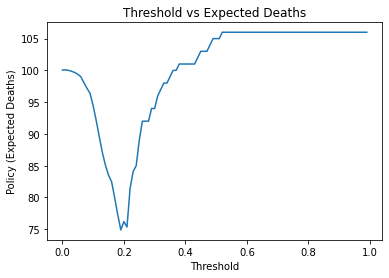

Optimal Threshold =  0.19


In [9]:
def plot_ED(thresholds):
  probs = model.predict_proba(X_val)
  probs = probs[:,1]  # positive class

  plot_x = np.empty(len(thresholds))
  plot_y = thresholds
  for i,thr in enumerate(thresholds):
    N = len(y_val[probs > thr])

    if N == 0:   ## if no patients to help, trivially true P(fail) is 0
      p_fail = 0
    else:
      t = ((60 / 25.0) * len(X_val)) / N
      p_fail = math.exp(-1 * (t * t) / 100.0)

    tpc = np.count_nonzero(y_val[probs > thr])
    fnc = np.count_nonzero(y_val[probs <= thr])
    plot_x[i] = p_fail * tpc + fnc

  plt.title('Threshold vs Expected Deaths')
  plt.xlabel("Threshold")
  plt.ylabel("Policy (Expected Deaths)")
  plt.plot(plot_y, plot_x)
  plt.show()
  
  val = np.argmin(plot_x)
  return thresholds[val]

optimal_threshold = plot_ED(np.arange(0, 1, 0.01))
print("Optimal Threshold = ", optimal_threshold)

Looking at the plot for Threshold vs. Expected Deaths, it appears that the threshold that outputs the minimum number of expected deaths is $0.19$

### g) Modelling Doctors' Decision-Making - Testing (7 points)

On the test set, compare the total number of expected deaths under the best policy that was selected in Part (f) to reviewing each patient's file. In relative terms (i.e., as a percentage), how many lives would be saved, if the assumptions underlying our simulation are accurate?

In [10]:
best_policy = 0.19  ## 0.19

## Under best policy
test_probs = model.predict_proba(X_test)
test_probs = test_probs[:,1]  # positive class

N = len(y_test[test_probs > best_policy])
t = ((60 / 25.0) * len(X_test)) / N
p_fail = math.exp(-1 * (t * t) / 100.0)

tp = np.count_nonzero(y_test[test_probs > best_policy])
fn = np.count_nonzero(y_test[test_probs <= best_policy])
expected_deaths_pol = p_fail * tp + fn
print("Expected Deaths for the test set under policy {} = {}".format(best_policy, expected_deaths_pol))

## Reviewing Each patients files
total_death = np.count_nonzero(y_test)
percent_lives_saved = 1 - (expected_deaths_pol / total_death)
print("Percent of lives saved = {}%".format(percent_lives_saved * 100))

Expected Deaths for the test set under policy 0.19 = 87.24116338547984
Percent of lives saved = 26.066810690271325%


With optimal threshold at $0.19$, the total expected number of deaths is about $87.24$. This means that about $26.1\%$ of lives would be saved when compared to reviewing each patients file.

## Question 2 - Neural Networks
---

We will train a fully connected neural networks to recognize face images of cats and dogs. 

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [12]:
data_dir = 'pets'
image_width = 32
image_height = 32
batch_size = 10

### a) Load the Pets Dataset (2 points)
There are 110 images of size $32\times32$. Run the following code block to import the data. Keep in mind that they will be downloaded from the internet, so it may take a while.

In [13]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [14]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [15]:
# Download the data
downloaded = drive.CreateFile({'id':"1cA-dQ4tXusV0hQLK3JieI8GXQdvxNwbs"})
downloaded.GetContentFile('pets.npy')  
data = np.load("pets.npy",allow_pickle=True)

In [16]:
# Create X and y
X, y = (data[()]['X'], data[()]['y'])

In [17]:
# Get class names and create ID
class_names = ['cat', 'dog']
class_dict = {i:class_name for i,class_name in enumerate(class_names)}

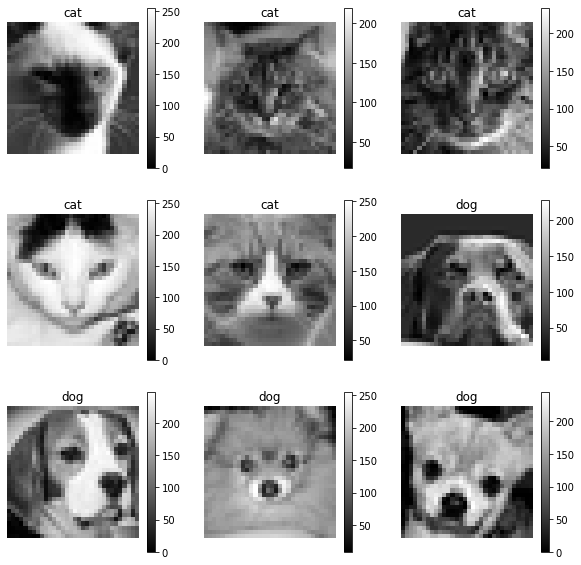

In [18]:
# Plot some images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for count, i in enumerate(range(0,110, 13)):
    ax = plt.subplot(3, 3, count + 1)
    plt.imshow(X[i],cmap='gray')
    plt.colorbar()
    plt.title(class_names[y[i]])
    plt.axis("off")

Answer the following questions:

1.) What are the data types for X and y?

2.) What are the shapes of X and y?

3.) What is the minimum and maximum value of X?

In [19]:
print(type(X), type(y))
print(X.shape, y.shape)
print(np.min(X), np.max(X))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(110, 32, 32) (110,)
0 255


1. X and y are ```numpy.ndarray``` types (multidimensional arrays).
2. X has a shape of ```(110, 32, 32)```, or a matrix of 110 labels with each having 32 x 32 sized images and y as a shape of ```(110,)```, or a vector of 110 labels.
3. Minimum value of X is $0$ and maximum value of X is $255$

### b) Data Preprocessing (3 points)
As you can see above, the pixel values are in the [0,255]. This is the normal range for images. Recall from the previous lectures and excercises that we need to normalize our data.

In order to normalize our data to [0,1] we use the equation:

$$x_{norm}=\frac{x-x_{min}}{x_{max}-x_{min}}$$

In our case we can assume that $x_{min}=0$ and $x_{max}=255$, this is a safe assumption since we are working with image data.

This means that for image data, if we want to normlize to [0,1] the equation simplifies to:

$$img_{norm}=\frac{img}{255}$$

Anytime you work with image data in any kind of model you will be normalizing with this equation. Unless the range you want to normalize is different. Sometimes you want to normalize between [-1,1], for that you would use a slightly different equation.


Normalize the X data using the above equation and save as train_images.

In [20]:
train_images =  X / 255.0

If we show the image agian, you will see the values are all scaled correctly.

0.0 1.0


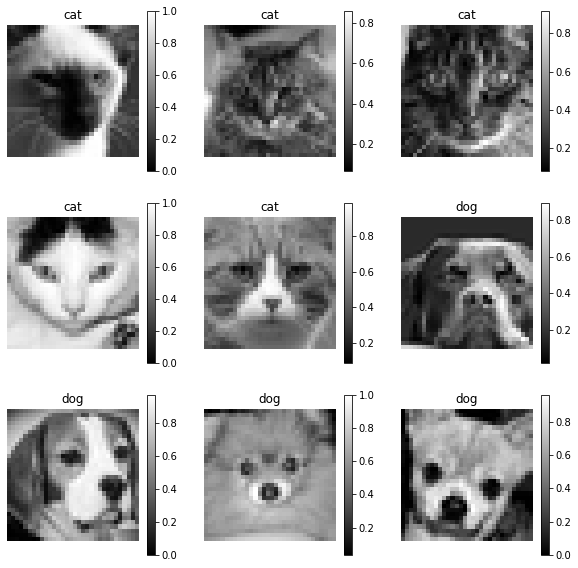

In [21]:
# Plot images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for count, i in enumerate(range(0,110, 13)):
    ax = plt.subplot(3, 3, count + 1)
    plt.imshow(train_images[i],cmap='gray')
    plt.colorbar()
    plt.title(class_names[y[i]])
    plt.axis("off")

print(np.min(train_images), np.max(train_images))

What is the new minimum and maximum value of X?

The new minimum value of X is $0.0$ and the new maximum value of X is $1.0$

### c) Reshaping the Data (5 points)

Please reshpe training images to be 1024-dim (from $32 \times 32$). 

Hint: look into numpy.reshape().


In [22]:
print(f'Before reshape, train_images shape: {train_images.shape}')

train_images = np.reshape(train_images, (110, 1024))

print(f'Before reshape, train_images shape: {train_images.shape}')


Before reshape, train_images shape: (110, 32, 32)
Before reshape, train_images shape: (110, 1024)


### d) Building a Simple Neural Network (15 points)
In the cell below, build a fully-connected feed-forward neural network with the following layers:
* **input layer** of shape 1024
* **hidden layer** with 25 neurons, and relu activation
* **output layer** with 1 neuron, and sigmoid activation

In [23]:
from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *

# Build neural network
def build_simple_model():
  input_layer = Input(shape=(1024))
  x = Dense(25, activation='relu')(input_layer)
  x = Dense(1, activation='sigmoid')(x)
  return Model(input_layer, x)

model = build_simple_model()

In [24]:
# Show a summary of your model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 25)                25625     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 25,651
Trainable params: 25,651
Non-trainable params: 0
_________________________________________________________________


Declare the optimizer using Stochastic Gradient Descient with learning rate of 0.001, weight decay of 1e-6 and momentum of 0.009. Compile your model using the 'binary_crossentropy' loss function and 'accuracy' as the metrics.

In [25]:
# Declare optimizer
optimizer_ = SGD(learning_rate=0.001, decay=1e-6, momentum=0.009)

# Compile model
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer_,
              metrics=['accuracy'])

Now we will train our model to learn pet faces using train_images and the 'y' labels. Our dataset is small so we will use 10% of the data as test set data. Train your model using the following parameters:

Fit your model using the train_images, 'y' labels, a batchsize of 10, and validation split of 0.1. Train for 500 epochs.

.fit documentation: https://www.tensorflow.org/api_docs/python/tf/keras/Model

In [26]:
y = y.reshape(-1,1)

# Call fit on your model passing in the X, y data above, train for 500 epochs
hist =  model.fit(train_images, 
                  y,
                  epochs=500,
                  batch_size=10,
                  validation_split=0.1)

Epoch 1/500
10/10 [==============================] - 1s 26ms/step - loss: 0.7450 - accuracy: 0.4545 - val_loss: 0.5917 - val_accuracy: 0.9091
Epoch 2/500
10/10 [==============================] - 0s 3ms/step - loss: 0.7271 - accuracy: 0.4343 - val_loss: 0.6250 - val_accuracy: 0.9091
Epoch 3/500
10/10 [==============================] - 0s 3ms/step - loss: 0.7098 - accuracy: 0.4444 - val_loss: 0.6521 - val_accuracy: 0.8182
Epoch 4/500
10/10 [==============================] - 0s 4ms/step - loss: 0.7008 - accuracy: 0.4949 - val_loss: 0.6781 - val_accuracy: 0.5455
Epoch 5/500
10/10 [==============================] - 0s 4ms/step - loss: 0.6900 - accuracy: 0.5152 - val_loss: 0.6969 - val_accuracy: 0.4545
Epoch 6/500
10/10 [==============================] - 0s 4ms/step - loss: 0.6827 - accuracy: 0.5354 - val_loss: 0.7076 - val_accuracy: 0.4545
Epoch 7/500
10/10 [==============================] - 0s 4ms/step - loss: 0.6771 - accuracy: 0.5657 - val_loss: 0.7139 - val_accuracy: 0.4545
Epoch 8/500


In [27]:
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

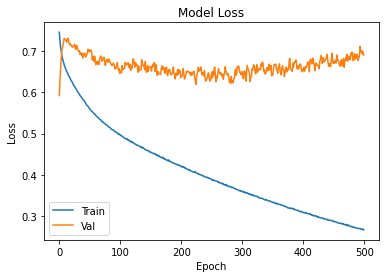

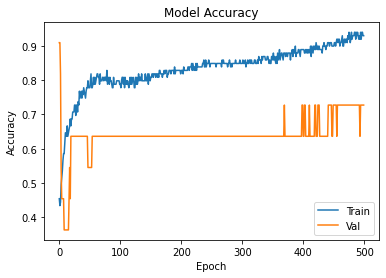

In [28]:
# plot your losses and accuracies
plot_losses(hist)
plot_accuracies(hist)


For the input size, this one hidden layer neural network is probably too small. However, we can see that the model attempts to minimize the overall loss. Summarize your observations on the model's learning curves, model's overall classification accuracy on the validation set, and the least amount of loss on validation set?

When looking at the plot for ```Model Loss```, it is apparent that the loss for the training set decreases close to 0.3 as the number of epochs increases. This is not the case with the validation set, as the loss of the validation decreased to its lowest between $0.65$ and $0.72$ in the middle epochs between $200$ and $300$ then increased afterwards towards 0.8. The gap between the training set and validation set loss increases as the number of epochs passes.

In the plot for ```Model Accuracy``` the accuracy of the model on the training set's accuracy steadily increases from 0.4 to about 0.9 as the number of epochs increases. On the validation set, the accuracy starts at 0.0 in the beginning epochs and increases in step increments until it converges between $0.6$ and $0.7$. Afterwards, the validation set accuracy stays constant at that value while the accuracy of the training set continues to increase. 

### e) Building a Second Neural Network (15 points)
Next, you will build a neural network with one hidden layer that is wider than the previous model's hidden layer. In the cell below, build a neural network with the following layers:
* **input layer** of shape 1024
* **hidden layer** with 100 neurons, and relu activation
* **output layer** with 1 neuron, and sigmoid activation

In [29]:
# Build Neural network
def build_second_model():
  input_layer = Input(shape=(1024))
  x = Dense(100, activation='relu')(input_layer)
  x = Dense(1, activation='sigmoid')(x)
  return Model(input_layer, x)

model = build_second_model()

In [30]:
# Show a summary of your model
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               102500    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 102,601
Trainable params: 102,601
Non-trainable params: 0
_________________________________________________________________


Again, declare the optimizer using Stochastic Gradient Descient with learning rate of 0.001, weight decay of 1e-6 and momentum of 0.009. Compile your model using 'binary_crossentropy' loss function and 'accuracy' as the metrics.

In [31]:
# Declare optimizer
optimizer_ = SGD(learning_rate=0.001, decay=1e-6, momentum=0.009)

# Compile model
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer_,
              metrics=['accuracy'])

In this sell fit your model using the train images, y labels, a batchsize of 10, and validation split of 0.1. Train for 500 epochs.

In [32]:
y = y.reshape(-1,1)

# Call fit on your model passing in the X, y data above, train for 500 epochs
hist = model.fit(train_images, 
                  y,
                  epochs=500,
                  batch_size=10,
                  validation_split=0.1)

Epoch 1/500
10/10 [==============================] - 1s 18ms/step - loss: 0.7196 - accuracy: 0.4848 - val_loss: 0.6101 - val_accuracy: 0.9091
Epoch 2/500
10/10 [==============================] - 0s 5ms/step - loss: 0.6910 - accuracy: 0.5354 - val_loss: 0.6594 - val_accuracy: 0.7273
Epoch 3/500
10/10 [==============================] - 0s 4ms/step - loss: 0.6773 - accuracy: 0.6061 - val_loss: 0.7038 - val_accuracy: 0.4545
Epoch 4/500
10/10 [==============================] - 0s 4ms/step - loss: 0.6696 - accuracy: 0.6061 - val_loss: 0.7289 - val_accuracy: 0.2727
Epoch 5/500
10/10 [==============================] - 0s 4ms/step - loss: 0.6625 - accuracy: 0.6263 - val_loss: 0.7468 - val_accuracy: 0.2727
Epoch 6/500
10/10 [==============================] - 0s 4ms/step - loss: 0.6562 - accuracy: 0.6162 - val_loss: 0.7430 - val_accuracy: 0.2727
Epoch 7/500
10/10 [==============================] - 0s 4ms/step - loss: 0.6509 - accuracy: 0.6162 - val_loss: 0.7494 - val_accuracy: 0.2727
Epoch 8/500


In [33]:
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

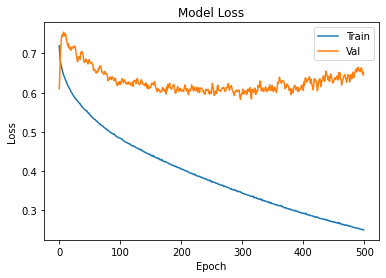

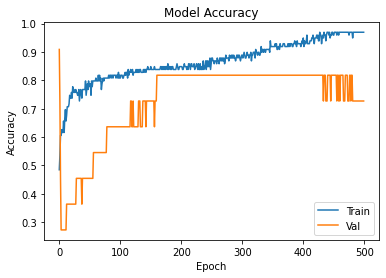

In [34]:
# Plot your losses and accuracies
plot_losses(hist)
plot_accuracies(hist)

Next, summarize this models results. Consider the following questions when answering. Remember that this model has a higher learning capacity than the previous model. 

1) How did this model compare to previous model? 

2) Did it outperform the previous models? 

3) What was your model's overall classification accuracy on the validation set and the least amount of loss on validation set? 

In the plot for ```Model Loss```, the loss of the training set decreases to about 0.2 as the number of epochs increases, similar to the previous model. The loss of the validation set follows a similar trend where it decreases its minimum loss between $0.6$ and $0.7$ at around epoch 200 then increases towards 0.8. Looking at loss, it appears that the model reached minimum loss in less epochs due to its higher learning rate.

In the plot for ```Model Accuracy```, the accuracy of the training set is higher when compared to the other model, as it increases from 0.6 to close to 0.95 at the end epochs. The validation set trend has higher jumps in accuracy in the early epochs then fluctuates between $0.7$ and $0.8$ after epoch 200, whereas the previous model converged to a single value.

It looks like the distance between the validation set trends and the training set trends are smaller than that on the simpler model. This means that this model performs slightly better as the predictive capabilities of the model are more generalizable than the simpler model due to the smaller error.

This model has lower overall loss on the validation set between $0.6$ and $0.7$. The model's overall classification accuracy on the validation set is slightly higher at around $0.73$.

### f) Building a Third Neural Network (15 points)
Lastly, you will build a fully-connected neural network with two hidden layers. In the cell below, build a neural network with the following layers:
* **input layer** of shape 1024
* **hidden layer** with 100 neurons, and relu activation
* **hidden layer** with 25 neurons, and relu activation
* **output layer** with 1 neuron, and sigmoid activation

In [35]:
from tensorflow.keras.layers import Input, Dense # only use these layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import * # you can use any optimizer

# Build Neural network
def build_third_model():
  input_layer = Input(shape=(1024))
  x = Dense(100, activation='relu')(input_layer)
  x = Dense(25, activation='relu')(x)
  x = Dense(1, activation='sigmoid')(x)
  return Model(input_layer, x)

model = build_second_model()

In [36]:
# Show a summary of your model
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               102500    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 102,601
Trainable params: 102,601
Non-trainable params: 0
_________________________________________________________________


Since this model is bigger than the previous models, we will use a more powerful optimizer. Declare the optimizer as Adam with learning rate of 0.001. Compile your model using 'binary_crossentropy' loss function and 'accuracy' as the metrics.

In [37]:
# Declare optimizer
optimizer =  Adam(learning_rate=0.001)

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In this sell fit your model using the train images, y labels, a batchsize of 10, and validation split of 0.1. Train for 500 epochs.

In [38]:
y = y.reshape(-1,1)

# Call fit on your model passing in the X, y. 
# Train for 500 epochs with a batch size of 10 and validation split of 0.1
hist = model.fit(train_images, 
                  y,
                  epochs=500,
                  batch_size=10,
                  validation_split=0.1)

Epoch 1/500
10/10 [==============================] - 1s 17ms/step - loss: 0.7228 - accuracy: 0.5556 - val_loss: 0.5894 - val_accuracy: 0.7273
Epoch 2/500
10/10 [==============================] - 0s 4ms/step - loss: 0.6028 - accuracy: 0.6667 - val_loss: 0.7983 - val_accuracy: 0.2727
Epoch 3/500
10/10 [==============================] - 0s 4ms/step - loss: 0.5007 - accuracy: 0.7677 - val_loss: 0.5959 - val_accuracy: 0.7273
Epoch 4/500
10/10 [==============================] - 0s 5ms/step - loss: 0.4613 - accuracy: 0.8081 - val_loss: 0.8787 - val_accuracy: 0.3636
Epoch 5/500
10/10 [==============================] - 0s 4ms/step - loss: 0.4687 - accuracy: 0.7576 - val_loss: 0.2088 - val_accuracy: 1.0000
Epoch 6/500
10/10 [==============================] - 0s 4ms/step - loss: 0.4361 - accuracy: 0.7778 - val_loss: 1.0504 - val_accuracy: 0.1818
Epoch 7/500
10/10 [==============================] - 0s 5ms/step - loss: 0.4511 - accuracy: 0.7980 - val_loss: 0.9469 - val_accuracy: 0.4545
Epoch 8/500


In [39]:
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

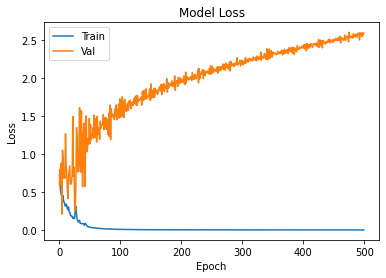

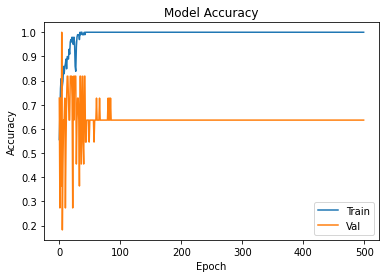

In [40]:
# plot your losses and accuracies
plot_losses(hist)
plot_accuracies(hist)

Summarize this model's results. Consider the following when answering:

1) How did this model compare to previous models? 

2) Did it outperform the previous models? 

3) What was your model's overall classification accuracy on the validation set and the least amount of loss on validation set? 

4) Adam is a powerful optimizer, and may quickly converge to an a minima. Did this happen with this model?

1. Looking at the plot for ```Model Loss```, the trend is much different as the loss of the validation set fluctuates between 0.5 and 1.5 then increases up to 2.5, wheras previous model loss trends decrease as the number of epochs pass until a minimum is reached. The training loss converged to 0 quickly in less than 100 epochs while the other models' training loss steadily converged towards 0 as the epochs passed. In the plot for ```Model Accuracy``` the validation set accuracy quickly converges at a minimum in less than 100 epochs and fluctuates between 0.53 and 65 for the remainder of the epochs. The ```Adam``` optimizer appears to quickly find a minimum and jumps between a small range until convergence is reaches. 

2. Yes, this optimizer outperforms the previous models in terms of the number of epochs it takes to find a minimum loss. It has a noticeably unstable trend and has larger jump intervals, allowing it to find convergence quickly. After convergence was reached, the loss continued to increase while the accuracy remained the same, meaning that overfitting occurs in much less epochs than other models. Early stopping would be necessary for this optimizer to have the best performance in terms of loss and accuracy.

3. With the ```Adam``` optimizer, the overall classification accuracy on the validation set is around $0.65$, and the least amount of loss on the validation set is around $0.5$.

4. Yes, based on the trends, it appears that Adam did reach a minima very quickly in less than $100$ epochs as opposed to the other optimizers. 